In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import hemcee

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This demo is the same as the one in `tutorial.ipynb`, but using TensorFlow to define the model instead of computing the gradients by hand.

In [3]:
# Generate a random covariance matrix
np.random.seed(42)
ndim = 10
L = np.random.randn(ndim, ndim)
L[np.diag_indices_from(L)] = np.exp(L[np.diag_indices_from(L)])
L[np.triu_indices_from(L, 1)] = 0.0
cov = np.dot(L, L.T)

params = tf.Variable(np.random.multivariate_normal(np.zeros(ndim), cov), dtype=tf.float64)

log_prob = -0.5 * tf.reduce_sum(params * tf.cholesky_solve(L, params[:, None])[:, 0])

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("Initial log prob: {0}".format(session.run(log_prob)))
    print("Initial gradient: {0}".format(
        session.run(tf.gradients(log_prob, params))))

Initial log prob: -3.3953190610195154
Initial gradient: [array([-0.59580213, -3.94052527,  0.78562519,  1.59169155,  0.25427602,
       -2.21061287,  1.70559426,  0.26855219, -1.17491634, -2.06235095])]


There is one step that is needed to wrap TensorFlow models for use with hemcee.
I normally define a class like this:

In [4]:
class TFModel(object):
    """A wrapper to expose TensorFlow models to Python interfaces
    
    Args:
        target: A tensor with the target log probability or cost
        var_list: A list of tensors or variables that should be fit
        feed_dict (optional): Any feed dict that should be used
        session (optional): The current session
    
    """
    def __init__(self, target, var_list, feed_dict=None, session=None):
        self.target = target
        self.var_list = var_list
        self.grad_target = tf.gradients(self.target, self.var_list)
        self.feed_dict = {} if feed_dict is None else feed_dict
        self._session = session

    @property
    def session(self):
        if self._session is None:
            return tf.get_default_session()
        return self._session

    def value(self, vector):
        feed_dict = self.vector_to_feed_dict(vector)
        return self.session.run(self.target, feed_dict=feed_dict)

    def gradient(self, vector):
        feed_dict = self.vector_to_feed_dict(vector)
        return np.concatenate([
            np.reshape(g, s) for s, g in zip(
                self.sizes,
                self.session.run(self.grad_target, feed_dict=feed_dict))
        ])

    def setup(self, session=None):
        if session is not None:
            self._session = session
        values = self.session.run(self.var_list)
        self.sizes = [np.size(v) for v in values]
        self.shapes = [np.shape(v) for v in values]

    def vector_to_feed_dict(self, vector):
        i = 0
        fd = dict(self.feed_dict)
        for var, size, shape in zip(self.var_list, self.sizes, self.shapes):
            fd[var] = np.reshape(vector[i:i+size], shape)
            i += size
        return fd

    def feed_dict_to_vector(self, feed_dict):
        return np.concatenate([
            np.reshape(feed_dict[v], s)
            for v, s in zip(self.var_list, self.sizes)])

    def current_vector(self):
        values = self.session.run(self.var_list)
        return np.concatenate([
            np.reshape(v, s)
            for v, s in zip(values, self.sizes)])

Then to wrap the model, I would use this syntax:

In [5]:
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

model = TFModel(log_prob, var_list=[params])
model.setup()

coords = model.current_vector()
print("Model value: {0}".format(model.value(coords)))
print("Model gradient: {0}".format(model.gradient(coords)))

Model value: -3.3953190610195154
Model gradient: [-0.59580213 -3.94052527  0.78562519  1.59169155  0.25427602 -2.21061287
  1.70559426  0.26855219 -1.17491634 -2.06235095]


The value and gradients here should be the same as the ones that you got above.

Then we set up the sampler using this model:

In [6]:
# Choose a dense metric that we will tune
metric = hemcee.metric.DenseMetric(np.eye(ndim))

# We will also tune the step size
step = hemcee.step_size.VariableStepSize()

# Set up the sampler
sampler = hemcee.NoUTurnSampler(model.value, model.gradient, step_size=step, metric=metric)

All Hamiltonian samplers require a tuning phase (often called "warmup" or "burn in").
During this phase, the step size and metric are automatically tuned:

In [7]:
coords = np.random.randn(ndim)
results = sampler.run_warmup(coords, 5000)

initial warm up: step_size: 1.6e-02; mean(accept_stat): 0.479: 100%|██████████| 100/100 [00:01<00:00, 85.78it/s]
warm up 1/8: step_size: 4.6e-02; mean(accept_stat): 0.476: 100%|██████████| 25/25 [00:00<00:00, 71.05it/s]
warm up 2/8: step_size: 2.5e+00; mean(accept_stat): 0.486: 100%|██████████| 25/25 [00:00<00:00, 81.00it/s]
warm up 3/8: step_size: 4.0e-01; mean(accept_stat): 0.498: 100%|██████████| 50/50 [00:00<00:00, 87.97it/s]
warm up 4/8: step_size: 6.6e-01; mean(accept_stat): 0.497: 100%|██████████| 100/100 [00:00<00:00, 160.43it/s]
warm up 5/8: step_size: 1.2e+00; mean(accept_stat): 0.496: 100%|██████████| 200/200 [00:00<00:00, 204.55it/s]
warm up 6/8: step_size: 1.1e+00; mean(accept_stat): 0.500: 100%|██████████| 400/400 [00:01<00:00, 229.00it/s]
warm up 7/8: step_size: 1.3e+00; mean(accept_stat): 0.500: 100%|██████████| 800/800 [00:03<00:00, 235.60it/s]
warm up 8/8: step_size: 1.4e+00; mean(accept_stat): 0.500: 100%|██████████| 3200/3200 [00:13<00:00, 241.38it/s]
final warm up:

After burning in, we can run the production MCMC chain:

In [8]:
coords_chain, logprob_chain = sampler.run_mcmc(results[0], 5000, initial_log_prob=results[1])

step_size: 9.5e-01; mean(accept_stat): 0.662: 100%|██████████| 5000/5000 [00:15<00:00, 333.11it/s]


Now, let's check the autocorrelation times:

In [9]:
taus = np.array([hemcee.autocorr.integrated_time(coords_chain[:, i])[0] for i in range(ndim)])
print("Mean autocorrelation time: {0}".format(np.mean(taus)))

Mean autocorrelation time: 1.0948805038155338


**Tip:** Reparameterization can often help sampling.
For example, if you have a parameter that is bounded in the range `(a, b)`, you can often get better performance by changing variables to one where the parameter has infinite support.
One way to do this with TensorFlow is:

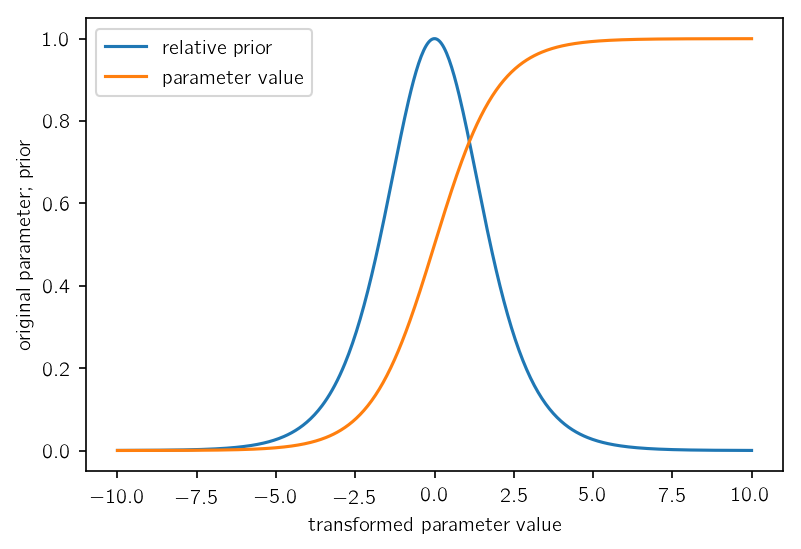

In [10]:
def get_bounded_for_value(value, min_value, max_value):
    if np.any(value <= min_value) or np.any(value >= max_value):
        raise ValueError("value must be in the range (min_value, max_value)")
    return np.log(value - min_value) - np.log(max_value - value)

def get_value_for_bounded(param, min_value, max_value):
    return min_value + (max_value - min_value) / (1.0 + np.exp(-param))

def get_bounded_variable(name, value, min_value, max_value, dtype=tf.float64):
    param = tf.Variable(get_bounded_for_value(value, min_value, max_value), dtype=dtype, name=name + "_param")
    var = min_value + (max_value - min_value) / (1.0 + tf.exp(-param))
    log_jacobian = tf.log(var - min_value) + tf.log(max_value - var) - np.log(max_value - min_value)
    return param, var, tf.reduce_sum(log_jacobian), (min_value, max_value)

# When doing reparameterizations, it can be useful to accumulate the prior
log_prior = tf.constant(0.0, dtype=tf.float64)

# Let's create a variable that is bounded between zero and one:
param, variable, log_jacobian, bounds = get_bounded_variable("bounded", 0.5, 0, 1)

# Don't forget to include the Jacobian of the transformation in the prior
log_prior += log_jacobian

param_values = np.linspace(-10, 10, 500)
variable_values = get_value_for_bounded(param_values, *bounds)
log_jac = [session.run(log_jacobian, feed_dict={param: p}) for p in param_values]

plt.plot(param_values, np.exp(log_jac) / np.exp(np.max(log_jac)), label="relative prior")
plt.plot(param_values, variable_values, label="parameter value")
plt.legend()
plt.xlabel("transformed parameter value")
plt.ylabel("original parameter; prior");